# Knihovna Scikit-learn, přehled užitečných funkcí

V předešlé hodině jsme se vyhýbali programování, jak jen se to dalo. Teď už si ale chceš také sama vše vyzkoušet.
Abys mohla úlohu rozmyšlenou v domácím úkolu naprogramovat, projdeme si nejdůležitější funkce, které budeš potřebovat. Použijeme jednoduchá data [salaries.csv](static/salaries.csv)

Především budeme používat knihovnu [Scikit-learn](https://scikit-learn.org) a samozrejmě také pandas. 
Potřebné věci projdeme na příkladu. 

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

## Načtení a příprava dat 

<table> 
    <tr><td>
        
☑ výběr vstupních proměnných 

☑ rozdělení na trénovací a testovací data 
        
☑ chybějící hodnoty 

☑ kategorické hodnoty 

☑ přeškálování / normování hodnot  
 </td></tr>
</table> 

Na začátku vždy bude potřeba připravit data. Čištění dat a použití knihovny pandas už bys měla ovládat, 
zaměříme se jen na věci, které jsou specifické pro strojové učení.

Načíst data tedy umíš.

In [2]:
df_salary = pd.read_csv("static/salaries.csv", index_col=0)
df_salary.sample(10)

,rank,discipline,yrs.since.phd,yrs.service,sex,salary
66,AssocProf,B,9,8,Male,100522
115,Prof,A,12,0,Female,105000
17,Prof,B,19,20,Male,101000
142,AssocProf,A,15,10,Male,81500
157,AssocProf,B,12,18,Male,113341
127,Prof,A,28,26,Male,155500
141,AssocProf,A,14,8,Male,100102
31,Prof,B,20,4,Male,132261
19,Prof,A,37,23,Male,124750
168,Prof,B,18,19,Male,130664


## Vytvoření trénovací a testovací množiny

Pro predikci použijeme jako příznaky `rank`, `discipline`, `yrs.since.phd`, `yrs.service` a `sex`, 
predikovat budeme hodnotu `salary`.  

V teorii strojového učení se vstupy modelu (příznaky, vstupní proměnné) typicky označují písmenem `X` a výstupy písmenem `y`. Řada programátorů toto používá i k označování proměnných v kódu. 
`X` představuje *matici* (neboli tabulku), kde každý řádek odpovídá jednomu datovému vzorku a každý sloupec jednomu příznaku (vstupní proměnné). `y` je vektor, neboli jeden sloupec s odezvou. 

(Na vyzobnutí odezvy se může hodit metoda [pop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pop.html). Její nevýhodou je ale nemožnost opakovaně spouštět buňku.)

In [3]:
y = df_salary["salary"]
X = df_salary.drop(columns=["salary"])

print(X.columns)
print(y.name)

Index(['rank', 'discipline', 'yrs.since.phd', 'yrs.service', 'sex'], dtype='object')
salary


In [4]:
X.head()

,rank,discipline,yrs.since.phd,yrs.service,sex
1,Prof,B,19,18,Male
2,Prof,B,20,16,Male
3,AsstProf,B,4,3,Male
4,Prof,B,45,39,Male
5,Prof,B,40,41,Male


In [5]:
y.head()

1    139750
2    173200
3     79750
4    115000
5    141500
Name: salary, dtype: int64

Zbývá data rozdělit na trénovací a testovací, to je třeba udělat co nejdříve, abychom při různých konverzích dat používali jen informace z trénovací množiny a testovací množina byla opravdu jen k evaluaci. K tomu slouží metoda [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train%20test%20split#sklearn.model_selection.train_test_split). 
Data nám rozdělí náhodně na trénovací a testovací sadu. Velikost testovací množiny můžeme specifikovat parametrem `test_size`, jeho defaultní hodnota je `0.25`, t. j. 25%.

In [6]:
from sklearn.model_selection import train_test_split 

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Kódování vstupů



Pro učení potřebujeme všechny hondoty převést na čísla (`float`). Pokud by data obsahovala chybějící
hodnoty, nejjednodušší řešení je takové řádky zahodit. (Bonus: pokud bys měla data s větším množstvím
chybějících hodnot, podívej se na možnosti [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute))

Dále je důležité vypořádat se s kategorickými hodnotami. Sloupce obsahující hodnoty typu Boolean nebo dvě hodnoty (např. muž/žena), lze snadno převést na hodnoty $[0,1]$. 

Pro kategorické proměnné s více možnostmi použijeme tzv. *onehot encoding*. 

Např. sloupec `rank` obsahuje hodnoty `Prof`, `AsstProf` a `AssocProf`. K zakódování pomocí onehot encoding potřebujeme tři sloupce: 

Původní hodnota | Kód 
--- | --- 
Prof      | 1 0 0
AsstProf  | 0 1 0 
AssocProf | 0 0 1  


Knihovna Scikitlearn nabízí [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). 

Při práci s pandas se může hodit i metoda [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). (Pozn. *dummies* proto, že nám přibudou pomocné proměnné (sloupce), které se označují jako *dummy variables*.) Ale pozor, pokud budeme později potřebovat stejným způsobem zakódovat další data, musí obsahovat stejné kategorie.

In [7]:
pd.get_dummies(X_train_raw).head()

,yrs.since.phd,yrs.service,rank_AssocProf,rank_AsstProf,rank_Prof,discipline_A,discipline_B,sex_Female,sex_Male
165,1,0,False,True,False,False,True,False,True
197,4,4,False,True,False,False,True,False,True
78,26,19,False,False,True,False,True,False,True
64,11,11,True,False,False,False,True,True,False
166,21,8,False,False,True,False,True,False,True


Naše data zakódujeme pomocí OneHotEncoder z knihovny Scikit-learn. 

In [8]:
X_train_raw.columns

Index(['rank', 'discipline', 'yrs.since.phd', 'yrs.service', 'sex'], dtype='object')

In [9]:
categorical_columns = ["rank", "discipline"] 
numerical_columns = ["yrs.since.phd", "yrs.service"]
# zbývá sloupec sex 

In [10]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(X_train_raw[categorical_columns])
column_names = encoder.get_feature_names_out()

In [11]:
column_names

array(['rank_AssocProf', 'rank_AsstProf', 'rank_Prof', 'discipline_A',
       'discipline_B'], dtype=object)

In [12]:
encoder.transform(X_train_raw[categorical_columns])

<138x5 sparse matrix of type '<class 'numpy.float64'>'
	with 276 stored elements in Compressed Sparse Row format>

In [13]:
encoder1 = OneHotEncoder(sparse_output=False)
encoder1.fit(X_train_raw[categorical_columns])
encoder1.transform(X_train_raw[categorical_columns])

array([[0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 1.

In [14]:
from sklearn.compose import make_column_transformer

In [15]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"),categorical_columns),
    remainder="passthrough"
)

In [16]:
transformer.fit(X_train_raw)
transformer.transform(X_train_raw)

array([[0.0, 1.0, 0.0, ..., 1, 0, 'Male'],
       [0.0, 1.0, 0.0, ..., 4, 4, 'Male'],
       [0.0, 0.0, 1.0, ..., 26, 19, 'Male'],
       ...,
       [0.0, 1.0, 0.0, ..., 3, 3, 'Female'],
       [0.0, 0.0, 1.0, ..., 25, 25, 'Female'],
       [0.0, 0.0, 1.0, ..., 15, 14, 'Male']], dtype=object)

In [17]:
transformer.get_feature_names_out()

array(['onehotencoder__rank_AssocProf', 'onehotencoder__rank_AsstProf',
       'onehotencoder__rank_Prof', 'onehotencoder__discipline_A',
       'onehotencoder__discipline_B', 'remainder__yrs.since.phd',
       'remainder__yrs.service', 'remainder__sex'], dtype=object)

In [18]:
from sklearn.preprocessing import OrdinalEncoder

In [19]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_columns),
    (OrdinalEncoder(), ["sex"]),
    remainder="passthrough"
)

In [20]:
X_train_transformed = transformer.fit_transform(X_train_raw)
X_test_transformed = transformer.transform(X_test_raw)

In [21]:
transformer.get_feature_names_out(), pd.DataFrame(X_test_transformed).head(10)

(array(['onehotencoder__rank_AssocProf', 'onehotencoder__rank_AsstProf',
        'onehotencoder__rank_Prof', 'onehotencoder__discipline_A',
        'onehotencoder__discipline_B', 'ordinalencoder__sex',
        'remainder__yrs.since.phd', 'remainder__yrs.service'], dtype=object),
      0    1    2    3    4    5     6     7
 0  1.0  0.0  0.0  1.0  0.0  1.0  19.0  16.0
 1  0.0  0.0  1.0  1.0  0.0  1.0  35.0  23.0
 2  0.0  0.0  1.0  0.0  1.0  1.0  17.0   3.0
 3  0.0  1.0  0.0  0.0  1.0  1.0   3.0   1.0
 4  1.0  0.0  0.0  0.0  1.0  1.0   8.0   8.0
 5  0.0  1.0  0.0  0.0  1.0  1.0   5.0   5.0
 6  1.0  0.0  0.0  0.0  1.0  1.0  12.0   8.0
 7  0.0  0.0  1.0  1.0  0.0  1.0  56.0  57.0
 8  0.0  1.0  0.0  1.0  0.0  0.0   3.0   1.0
 9  0.0  0.0  1.0  0.0  1.0  1.0  37.0  37.0)

## Škálování

Přeškálování není vždy nutné, ale některým modelům to může pomoci. Řiďte se tedy pravidlem, že rozhodně neuškodí.
Využijeme [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

StandardScaler nám hodnoty přeškáluje, aby zhruba odpovídaly normálnímu rozdělení. Některé algoritmy to předpokládají. Pokud bychom neškálovali, mohlo by se stát, že příznak (sloupeček), která má výrazně větší rozptyl než ostatní, je brán jako významnější. 

Nejprve si ukažme jednoduchý příklad.

In [22]:
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt
import seaborn as sns 

# vygeneruje 20 náhodných bodů
example = pd.DataFrame({"a": 100+np.random.randn(100), "b": 100*np.random.randn(100)})
example.head(20)

,a,b
0,100.888984,-260.878801
1,100.496064,-65.508528
2,100.055572,59.374218
3,100.060233,121.281507
4,98.560538,20.311355
5,99.616512,4.957273
6,100.886202,161.057846
7,99.766297,127.399339
8,100.044351,-86.858194
9,98.823873,11.641098


In [23]:
example.describe()

,a,b
count,100.000000,100.000000
mean,99.914380,-1.182795
std,0.967421,107.772840
min,97.540807,-260.878801
25%,99.252158,-75.710666
50%,99.846426,5.370076
75%,100.740273,66.216316
max,101.860778,217.284230


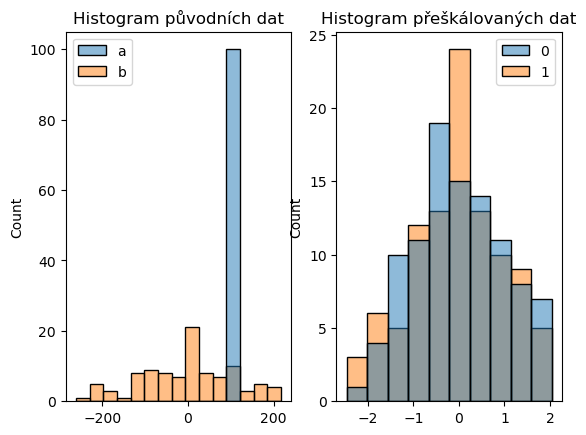

In [24]:
example_scaler = StandardScaler()
transformed_example = example_scaler.fit_transform(example)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title("Histogram původních dat")
sns.histplot(example, ax=ax1)
ax2.set_title("Histogram přeškálovaných dat")
sns.histplot(transformed_example, ax=ax2);

In [25]:
pd.DataFrame(transformed_example).describe()

,0,1
count,1.000000e+02,1.000000e+02
mean,8.699708e-15,5.551115e-18
std,1.005038e+00,1.005038e+00
min,-2.465865e+00,-2.421800e+00
25%,-6.879710e-01,-6.950112e-01
50%,-7.059610e-02,6.110893e-02
75%,8.580067e-01,6.285318e-01
max,2.022080e+00,2.037319e+00


In [26]:
pd.DataFrame(transformed_example).head()

,0,1
0,1.012500,-2.421800
1,0.604302,-0.599871
2,0.146683,0.564726
3,0.151525,1.142043
4,-1.406483,0.200444


Zpátky k našim datům. Transformaci musíme nastavit (fit) pouze na trénovacích datech, škálovat pak budeme stejným způsobem trénovací i testovací data.

In [27]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_transformed)
X_test = scaler.transform(X_test_transformed)

X_train

array([[-0.47036043,  1.85785169, -1.21007674, ...,  0.37482778,
        -1.52392312, -1.3377031 ],
       [-0.47036043,  1.85785169, -1.21007674, ...,  0.37482778,
        -1.27246669, -0.98473364],
       [-0.47036043, -0.5382561 ,  0.82639387, ...,  0.37482778,
         0.57154709,  0.33890184],
       ...,
       [-0.47036043,  1.85785169, -1.21007674, ..., -2.66789188,
        -1.3562855 , -1.072976  ],
       [-0.47036043, -0.5382561 ,  0.82639387, ..., -2.66789188,
         0.48772828,  0.86835603],
       [-0.47036043, -0.5382561 ,  0.82639387, ...,  0.37482778,
        -0.3504598 , -0.10230999]])

## Modely 

Můžeme přejít k samotnému učení. Vybereme si model. Přehled modelů najdeš v sekci [Supervised learnig](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
                                                                                                       
                                        
Na regresi můžeš použít:
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) 
 
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
     + hyperparametry: 
          * alpha, float, default=1.0 
 
- [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)        
     + hyperparametry:
          * kernel, default rbf, one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
          * C, float, optional (default=1.0)
          
Na klasifikační úlohy (ke kterým se dostaneme v příští hodině) využiješ: 
 
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
    
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
  + hyperparametry:
    * n_estimators, integer, optional (default=100)
   
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
  + hyperparametry:
     * C, float, optional (default=1.0)
     * kernelstring, optional (default=’rbf’)
  


Vytvoříme instanci vybraného modelu (jde nám teď jen o způsob použití knihovny, vezmeme nejjednodušší lineární regresi):

In [28]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

## Trénování

Model natrénujeme na trénovací množině:

In [29]:
model.fit(X_train, y_train)

LinearRegression()

## Predikce 

Natrénovaný model typicky chceme použít k ohodnocení nějakých nových datových vzorků, k tomu máme metodu `predict`. Zavolejme ji jak na trénovací, tak na testovací data.

In [30]:
train_predikce = model.predict(X_train)
test_predikce = model.predict(X_test)

Vypišme si prvních deset testovacích vzorků a jejich predikce:

In [31]:
print(f"skutečný plat    predicke platu     ")
for i in range(10):
    print(f"{y_test.iloc[i]:>10.2f}         {test_predikce[i]:>10.2f}")


skutečný plat    predicke platu     
  82100.00           85454.16
 134885.00          112335.62
 150480.00          126773.44
  86100.00           84785.42
 100000.00          102575.04
  91227.00           85896.89
 119800.00           99969.59
  76840.00          119177.70
  72500.00           68496.04
 152708.00          134266.88


# Jednoduchý dotaz 

Vyzkoušejte si zadat modelu svůj vlastní jednoduchý dotaz. K tomu můžete využít následující jednořádkový DataFrame.

In [32]:
dotaz = pd.DataFrame({
    "rank": "Prof",
    "discipline": "B",
    "yrs.since.phd": 15,
    "yrs.service": 10,
    "sex": "Male",
}, index=[0])
dotaz

,rank,discipline,yrs.since.phd,yrs.service,sex
0,Prof,B,15,10,Male


In [33]:
X_query = scaler.transform(transformer.transform(dotaz))

In [34]:
print(f"Odhadovaný plat vašeho pracovníka je: {model.predict(X_query)[0]:.2f}")

Odhadovaný plat vašeho pracovníka je: 132301.01


## Evaluace modelu

Můžeme využít funkci `score`, která nám vrátí hodnotu $R^2$ metriky:   

In [35]:
print("R2 na trénovací množině: ", model.score(X_train, y_train))
print("R2 na testovací množině: ", model.score(X_test, y_test))

R2 na trénovací množině:  0.5135908532845631
R2 na testovací množině:  0.5444018189943942


Funkce pro všechny možné metriky najdeš v [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#module-sklearn.metrics).
                                                            (nyní nás zajímají [regresní metriky](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#module-sklearn.metrics))          

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MAE_train = mean_absolute_error(y_train, train_predikce)
MAE_test  = mean_absolute_error(y_test, test_predikce)

MSE_train = mean_squared_error(y_train, train_predikce) 
MSE_test = mean_squared_error(y_test, test_predikce)

R2_train = r2_score(y_train, train_predikce)
R2_test = r2_score(y_test, test_predikce)

print("    Trénovací data  Testovací data")
print(f"MSE {MSE_train:>14.3f}  {MSE_test:>14.3f}")
print(f"MAE {MAE_train:>14.3f}  {MAE_test:>14.3f}")
print(f"R2  {R2_train:>14.3f}  {R2_test:>14.3f}")

    Trénovací data  Testovací data
MSE  421032608.678   317260319.429
MAE      14436.169       13600.608
R2           0.514           0.544


## Uložení modelu 

Někdy si potřebujeme naučený model uchovat na další použití. Model lze uložit do souboru a zase načíst pomocí `pickle`.
Kujme pikle:

In [37]:
import pickle 

with open("model.pickle", "wb") as soubor:
    pickle.dump(model, soubor)


with open("model.pickle", "rb") as soubor:
    staronovy_model = pickle.load(soubor)

staronovy_model.score(X_test, y_test)

0.5444018189943942

### Bonusy:

 - volba vhodného modelu a jeho hyper-parametrů se skrývá pod klíčovým slovem **model selection**. Knihovna Scikit-learn obsahuje různé pomůcky k ulehčení toho výběru. Přesahuje to ale rámec tohoto kurzu, narazíš-li na to toho téma při samostudiu, pročti si [sklear.model_selection](https://scikit-learn.org/stable/modules/classes.html?highlight=model%20selection#module-sklearn.model_selection). 
 
 - v příkladu výše jsme použili různé transformace nad daty a pak teprve tvorbu modelu. Až budeš v těchto věcech zběhlejší, bude se ti hodit propojit tyto věci dohromady. K tomu slouží tzv. [pipeline](https://scikit-learn.org/stable/modules/classes.html?highlight=pipeline#module-sklearn.pipeline).  